# Synthetic Controls for Wildfire Data in Italy

Apply synthetic control to see if the trend in area burned evolved differently in the independent regions who kept the Corpo Forestale, compared to all other regions where since 2017 the Carabinieri Forestali are the responsible authority.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import cvxpy as cp
import numpy as np
import os


from sklearn.linear_model import LinearRegression, HuberRegressor

import datetime


# time stamp in the format of 'YYYY-MM-DD'
PLOT_DIR = 'plots/'
os.makedirs(PLOT_DIR, exist_ok=True)
PAGE_WIDTH = 6.2677165  # page width in inches

# matplotlib set font size to 7 and font to Arial
plt.rc('font', size=7)
plt.rc('font', family='Arial')


def savefig(fig, name, path=PLOT_DIR):
    fig.savefig(os.path.join(path, f'{name}.pdf'), bbox_inches='tight')
    fig.savefig(os.path.join(path, f'{name}.png'), dpi=300, bbox_inches='tight')

def get_rmse(results, observed, regions, splits):
    return [np.sqrt(np.mean((results.loc[s][regions].values - observed.loc[s][regions].values)**2)) for s in splits]

# 1) Data Preprocessing


In [2]:
YEARS_TRAIN = [*range(2003,2015)]
YEARS_TEST = [*range(2015,2017)]
YEARS_VAL = [*range(2017,2022)]

YEARS = YEARS_TRAIN + YEARS_TEST + YEARS_VAL

## Units (regions with and without intervention)

In [3]:
df_units = pd.read_csv('data/units/units.csv', index_col='REGION')
EXCLUDED = df_units[df_units['UNIT'] == 'EXCLUDE'].index.values.tolist()
TREATED = df_units[df_units['UNIT'] == 'TREATED'].index.values.tolist()
CONTROL = df_units[df_units['UNIT'] == 'CONTROL'].index.values.tolist()
df_units = df_units[df_units['UNIT'] != 'EXCLUDE']
df_units

print('EXCLUDED', ', '.join(EXCLUDED))
print('TREATED', ', '.join(TREATED))
print('CONTROL', ', '.join(CONTROL))

EXCLUDED Provincia Autonoma di Trento, Valle d'Aosta
TREATED Abruzzo, Puglia, Basilicata, Calabria, Campania, Emilia-Romagna, Lazio, Liguria, Lombardia, Marche, Molise, Piemonte, Toscana, Umbria, Veneto
CONTROL Friuli-Venezia Giulia, Sardegna, Sicilia


## Wildfire Weather Index (FWI) Data

In [4]:
df_fwi = pd.read_csv('data/fwi-data/fwi_3mesi.csv', index_col='Year')
df_fwi

,Abruzzo,Basilicata,Calabria,Campania,Emilia-Romagna,Friuli-Venezia Giulia,Lazio,Liguria,Lombardia,Marche,Molise,Piemonte,Puglia,Sardegna,Sicilia,Toscana,Umbria,Veneto
Year,,,,,,,,,,,,,,,,,,
2003,0.61,0.62,0.60,0.76,0.76,0.88,0.82,0.67,0.48,0.61,0.54,0.36,0.70,0.95,0.67,0.97,0.82,0.87
2004,0.66,0.63,0.68,0.71,0.43,0.24,0.76,0.57,0.12,0.61,0.62,0.15,0.57,0.78,0.72,0.75,0.70,0.23
2005,0.39,0.54,0.61,0.49,0.36,0.28,0.55,0.45,0.30,0.34,0.41,0.26,0.67,0.82,0.76,0.52,0.47,0.54
2006,0.48,0.52,0.62,0.46,0.36,0.40,0.53,0.34,0.17,0.44,0.44,0.20,0.50,0.87,0.73,0.63,0.56,0.22
2007,0.85,0.96,0.97,0.92,0.65,0.35,0.81,0.57,0.51,0.75,0.96,0.37,0.81,0.80,0.93,0.72,0.72,0.37
2008,0.69,0.80,0.82,0.78,0.46,0.19,0.75,0.35,0.24,0.74,0.74,0.29,0.81,0.70,0.86,0.73,0.76,0.32
2009,0.46,0.61,0.69,0.64,0.51,0.37,0.60,0.45,0.24,0.44,0.49,0.22,0.61,0.81,0.74,0.76,0.58,0.46
2010,0.42,0.53,0.56,0.48,0.28,0.26,0.55,0.22,0.12,0.34,0.49,0.06,0.63,0.61,0.71,0.47,0.44,0.16
2011,0.68,0.73,0.90,0.75,0.49,0.36,0.68,0.58,0.35,0.71,0.68,0.36,0.69,0.75,0.86,0.72,0.64,0.48


In [5]:
df_fwi_eu = pd.read_excel('data/fwi-data/fwi_europe.xlsx').drop(columns={'iso3','iso_3166_1'}).set_index('name').T
df_fwi_eu.index.rename('year', inplace=True)
df_fwi_eu.rename(columns={'Czech Republic': 'Czechia'}, inplace=True)
df_fwi_eu.rename(columns={'Italy ordinary regions': 'Italy TREATED'}, inplace=True)
df_fwi_eu.rename(columns={'Italy 3 autonomous regions': 'Italy CONTROL'}, inplace=True)



df_fwi_eu.drop(index=[2000, 2001, 2002], inplace=True)
print(','.join(sorted(df_fwi_eu.columns)))
df_fwi_eu

Albania,Andorra,Austria,Belarus,Belgium,Bosnia & Herzegovina,Bulgaria,Croatia,Cyprus,Czechia,Denmark,Estonia,Faroe Islands,Finland,France,Germany,Greece,Hungary,Iceland,Ireland,Italy,Italy CONTROL,Italy TREATED,Latvia,Liechtenstein,Lithuania,Luxembourg,Malta,Moldova, Republic of,Monaco,Montenegro,Netherlands,Norway,Poland,Portugal,Romania,San Marino,Serbia,Slovakia,Slovenia,Spain,Sweden,Switzerland,The former Yugoslav Republic of Macedonia,Turkey,U.K. of Great Britain and Northern Ireland,Ukraine


name,Switzerland,Austria,Portugal,Luxembourg,Estonia,France,Serbia,Romania,Belarus,Norway,...,Hungary,Czechia,Spain,Cyprus,Sweden,Netherlands,Slovakia,Albania,Italy TREATED,Italy CONTROL
year,,,,,,,,,,,,,,,,,,,,,
2003,2.362233,3.030775,13.163608,4.537881,2.457376,6.657550,7.370221,6.372496,3.871768,0.926598,...,9.545015,5.534604,13.457349,20.706587,2.033063,4.251398,5.580660,8.163529,9.143885,12.222361
2004,0.966451,1.507597,13.984047,2.849563,2.047212,5.057377,4.514746,4.275076,3.295328,0.816168,...,5.263623,3.690248,13.585055,21.725144,1.626066,2.551507,2.844054,5.236524,6.511746,10.856873
2005,1.100532,1.665935,18.540802,3.511653,3.034164,5.467093,3.414412,3.086518,4.110376,0.692930,...,4.344253,2.943131,17.771743,21.904075,1.806272,2.387395,2.881587,4.997351,5.917211,10.955317
2006,1.222624,2.012308,13.196368,2.877684,5.184470,4.938441,4.524206,4.284567,3.852164,1.101051,...,5.615405,3.592963,14.706532,19.887545,2.478623,3.455591,3.523917,5.276440,7.043798,12.841800
2007,1.039492,2.526494,13.193772,2.526839,2.530981,4.077961,7.370237,7.629459,3.988947,0.869461,...,9.586044,4.102514,13.977619,21.077564,1.971620,2.796972,4.836877,8.086246,8.389833,12.566997
2008,0.829263,1.588525,12.488401,2.061019,2.527349,3.578981,7.073792,5.895818,3.181018,0.981428,...,6.671633,2.843966,12.953907,24.151451,2.034135,2.489098,3.118248,6.822314,7.100979,12.181048
2009,1.122464,1.554632,16.087425,3.056617,2.143882,5.491104,6.098444,6.569252,3.191544,0.849877,...,8.390594,3.039199,17.172190,19.233691,1.827514,3.604507,4.310748,5.631738,6.696697,11.045998
2010,0.745403,1.409456,13.256280,2.759269,2.107634,4.871966,4.326313,3.504813,3.260367,0.595992,...,2.975237,2.244040,12.228099,22.834781,1.333202,3.119248,1.833742,4.822842,4.795207,10.083331
2011,1.440110,2.384266,13.869333,4.156045,2.437855,6.140666,8.597320,6.875476,3.727671,0.554262,...,8.553310,3.240700,15.286775,18.364154,1.578687,3.387025,4.568035,8.133509,7.811494,11.616584


# Data Italian Authorities

In [6]:
df_italy_matrix = pd.read_csv('data/fire-activity-data/area_burned_italy.csv', index_col='Year')
df_italy_num_fires = pd.read_csv('data/fire-activity-data/num_fires_italy.csv', index_col='Year')

df_italy_matrix / df_italy_num_fires

,Abruzzo,Basilicata,Calabria,Campania,Emilia-Romagna,Friuli-Venezia Giulia,Lazio,Liguria,Lombardia,Marche,Molise,Piemonte,Puglia,Sardegna,Sicilia,Toscana,Umbria,Veneto
Year,,,,,,,,,,,,,,,,,,
2003,6.758242,6.152985,6.214973,4.349228,3.178771,7.503676,13.387001,9.099882,3.789610,2.930693,2.432432,11.245940,9.814433,17.776851,30.095469,6.539130,4.351724,3.783505
2004,10.482759,5.279817,7.615206,3.889262,1.458333,0.857143,10.223565,3.675362,4.070652,2.540541,1.785714,6.335329,8.252336,16.237668,17.745486,3.761468,1.969231,0.416667
2005,8.638889,6.096939,8.462103,1.325220,2.716667,0.581081,7.872289,11.612188,4.008163,1.375000,1.141818,6.717241,8.000000,4.402102,12.575362,2.234414,3.257576,0.804348
2006,7.371429,6.973856,7.196185,1.480387,2.384615,3.552846,7.195205,4.049738,5.290323,2.892857,1.504702,4.174825,10.748387,3.504417,14.689840,1.236253,1.183099,1.820513
2007,75.600000,19.294118,22.939362,3.281981,6.147239,1.847826,17.438303,9.415270,6.573913,47.480000,4.859927,9.326633,40.761983,10.408194,37.140239,2.293103,6.216049,1.542373
2008,6.484211,17.123779,14.080532,4.951189,1.226562,1.030303,7.925072,2.831615,7.457516,1.916667,4.897590,5.764331,17.467078,5.708160,22.301129,2.168860,2.939655,0.562500
2009,4.676471,7.330986,10.057263,6.868217,1.988372,4.849315,7.778462,7.963855,2.869565,3.315789,3.795918,3.188034,15.732852,54.245614,11.307087,3.347905,0.982143,0.545455
2010,5.921875,14.126667,7.987730,4.329650,1.105263,0.698113,8.895480,1.495575,3.878049,5.111111,5.094595,3.500000,10.613108,8.258469,17.478861,0.860606,2.750000,0.480000
2011,8.941176,10.362712,11.661551,5.662718,1.516667,3.795918,11.292282,5.177474,5.779736,5.345238,5.798450,4.282297,12.365517,12.473171,13.239367,1.588235,2.487805,4.710145


In [7]:
df_italy_matrix_forest = pd.read_csv('data/fire-activity-data/burnt_area_forest.csv', index_col='Year')
df_italy_matrix_forest.drop(columns=EXCLUDED, inplace=True)
df_italy_matrix_forest

,Abruzzo,Basilicata,Calabria,Campania,Emilia-Romagna,Friuli-Venezia Giulia,Lazio,Liguria,Lombardia,Marche,Molise,Piemonte,Puglia,Sardegna,Sicilia,Toscana,Umbria,Veneto
Year,,,,,,,,,,,,,,,,,,
2003,267,633,3193,3777,185,1441,5516,5069,688,205,80,2864,1559,8080,5246,4130,425,311
2004,232,370,3677,1617,25,15,2150,1024,448,52,50,493,649,5052,4076,815,73,4
2005,156,711,2689,1177,80,13,2498,3380,448,22,101,1192,931,3176,3815,525,215,6
2006,158,562,2834,1015,86,224,1024,1148,253,71,56,834,992,1903,4682,390,84,37
2007,10271,3617,24806,18699,409,97,8690,2485,666,3966,1249,2139,9954,12213,15328,809,1007,67
2008,291,2327,10236,2936,85,13,1701,411,597,28,319,698,4212,1767,4041,452,137,15
2009,104,651,4114,4881,69,198,1802,1489,268,38,75,286,1527,12270,1801,1407,44,30
2010,160,481,2439,1800,16,12,2460,162,151,41,87,132,2066,1934,7242,82,80,8
2011,440,1513,8174,5738,68,230,5597,1301,531,372,315,33,3327,3718,5227,680,217,390


In [8]:
df_effis_area = pd.read_csv('data/fire-activity-data/area_burned_eu.csv', index_col='year')
df_effis_number = pd.read_csv('data/fire-activity-data/num_fires_eu.csv', index_col='year')

df_effis_area.rename(columns={'Czech Republic': 'Czechia'}, inplace=True)
df_effis_number.rename(columns={'Czech Republic': 'Czechia'}, inplace=True)

# remove Morocco
df_effis_area.drop(columns=['Morocco'], inplace=True)
df_effis_number.drop(columns=['Morocco'], inplace=True)

print(', '.join(sorted(df_effis_area.columns)))
df_effis_area

Austria, Bulgaria, Croatia, Cyprus, Czechia, Estonia, Finland, France, Germany, Greece, Hungary, Italy, Latvia, Lithuania, Norway, Poland, Portugal, Romania, Slovakia, Slovenia, Spain, Sweden, Switzerland, Türkiye


,Italy,Portugal,Spain,France,Greece,Austria,Bulgaria,Croatia,Cyprus,Czechia,...,Latvia,Lithuania,Norway,Poland,Romania,Slovakia,Slovenia,Sweden,Switzerland,Türkiye
year,,,,,,,,,,,,,,,,,,,,,
2003,91805,471750,148172,73278,3517,122,5000,27091,2349,1236,...,559.0,436,942,21551.0,762.0,1567,2100,4002,673.0,6644.0
2004,60176,151370,134193,13711,10267,19,1137,3378,1218,335,...,486.0,253,117,3782.0,124.0,157,138,1883,31.0,4876.0
2005,47575,346718,188697,22135,6437,13,1456,3135,1838,227,...,120.0,51,346,5713.0,162.0,524,280,1562,67.0,2821.0
2006,39946,83706,155345,7972,12661,54,3540,4575,1160,53,...,3387.0,1199,3829,5657.0,946.0,280,1420,5710,127.0,7762.0
2007,227729,36413,86122,8574,225734,54,42999,20209,4483,316,...,272.0,38,128,2841.0,2529.0,679,128,1090,337.0,11664.0
2008,66329,19897,50322,6046,29152,20,5289,7343,2392,86,...,364.0,112,3174,3027.0,373.0,118,75,6113,68.0,29749.0
2009,73355,92126,120094,17033,35342,58,2271,2900,885,178,...,646.0,287,1329,4400.0,974.0,510,177,1537,60.0,4679.0
2010,46537,140953,54770,10538,8967,36,6526,1121,2000,205,...,92.0,22,769,2126.0,206.0,192,121,540,27.0,3517.0
2011,72004,77104,102161,11751,29144,67,6883,15555,1599,337,...,115.0,293,121,2678.0,2195.0,403,288,945,225.0,3612.0


In [9]:
df_land = pd.read_csv('data/units/landarea.csv')
df_land = df_land[['Reference area', 'Measure', 'OBS_VALUE', 'TIME_PERIOD']]
df_land = df_land[df_land['TIME_PERIOD'] == 2022]
 
# group by Measure into columns
df_land = df_land.pivot_table('OBS_VALUE', 'Reference area', 'Measure')

df_land

Measure,Forest,Land area,Total area
Reference area,,,
Afghanistan,12084.40,652230.0,652860.0
Albania,7889.00,27400.0,28750.0
Algeria,19681.11,2381741.0,2381741.0
American Samoa,170.70,200.0,200.0
Andorra,160.00,470.0,470.0
...,...,...,...
Viet Nam,147948.90,313429.0,331340.0
Wallis and Futuna,58.30,140.0,140.0
Yemen,5490.00,527970.0,527970.0


In [10]:
print(df_effis_area.columns)
df_units_eu = pd.DataFrame(index=df_effis_area.columns)

df_units_eu['FORESTCOVER'] = df_land.rename(index={'Slovak Republic' : 'Slovakia'}).loc[df_effis_area.columns]['Forest']
df_units_eu['LANDCOVER'] = df_land.rename(index={'Slovak Republic' : 'Slovakia'}).loc[df_effis_area.columns]['Land area']

df_units_eu

Index(['Italy', 'Portugal', 'Spain', 'France', 'Greece', 'Austria', 'Bulgaria',
       'Croatia', 'Cyprus', 'Czechia', 'Estonia', 'Finland', 'Germany',
       'Hungary', 'Latvia', 'Lithuania', 'Norway', 'Poland', 'Romania',
       'Slovakia', 'Slovenia', 'Sweden', 'Switzerland', 'Türkiye'],
      dtype='object')


,FORESTCOVER,LANDCOVER
Italy,96737.50,295720.00
Portugal,33120.00,91605.59
Spain,185807.50,499713.70
France,174198.00,547557.00
Greece,39018.00,128900.00
Austria,38954.50,82520.00
Bulgaria,39190.00,108560.00
Croatia,19441.10,55960.00
Cyprus,1724.90,9240.00
Czechia,26807.10,77171.73


In [11]:
df_effis_area['Italy TREATED'] = df_italy_matrix[TREATED].sum(axis=1)
df_effis_area['Italy CONTROL'] = df_italy_matrix[CONTROL].sum(axis=1)
df_effis_area

df_effis_number['Italy TREATED'] = df_italy_num_fires[TREATED].sum(axis=1)
df_effis_number['Italy CONTROL'] = df_italy_num_fires[CONTROL].sum(axis=1)
df_effis_number

landcover_treated = df_units['LANDCOVER'].loc[TREATED].sum()
landcover_control = df_units['LANDCOVER'].loc[CONTROL].sum()
forestcover_treated = df_units['FORESTCOVER'].loc[TREATED].sum()
forestcover_control = df_units['FORESTCOVER'].loc[CONTROL].sum()

# append rows to df_units_eu
df_units_eu.loc['Italy TREATED'] = [forestcover_treated, landcover_treated]
df_units_eu.loc['Italy CONTROL'] = [forestcover_control, landcover_control]
df_units_eu

,FORESTCOVER,LANDCOVER
Italy,96737.50,295720.00
Portugal,33120.00,91605.59
Spain,185807.50,499713.70
France,174198.00,547557.00
Greece,39018.00,128900.00
Austria,38954.50,82520.00
Bulgaria,39190.00,108560.00
Croatia,19441.10,55960.00
Cyprus,1724.90,9240.00
Czechia,26807.10,77171.73


In [12]:

def style_plot(ax, axhline=False, add_policy_change=False, ha='center'):
    testing_start = YEARS[-len(YEARS_VAL) - len(YEARS_TEST)] - 0.5
    validation_start = YEARS[-len(YEARS_VAL)] - 0.5
    # ax.axvline(testing_start, color='k', alpha=0.5, linestyle=':', linewidth=0.8)

    if axhline:
        ax.axhline(0, color='k', alpha=0.5)
    # ax.grid(visible=True, axis='x', linewidth=0.5, color='gainsboro')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if add_policy_change:
        ax.axvline(validation_start, ymax=0.9, color='k', alpha=0.5, linestyle=':', linewidth=1)
        # add policy change floating text
        if add_policy_change != 'line':
            ax.text(validation_start,  0.98*ax.get_ylim()[1], 'policy intervention',color='k', va='top', ha=ha)
        # ax.text(testing_start+0.5, 1. *ax.get_ylim()[1], 'Testing period',color='k', va='top')




Index([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020, 2021],
      dtype='int64', name='Year')


/var/folders/50/5nqq19kx6x19wr35z0vc95140000gn/T/ipykernel_90429/1292693797.py:34: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


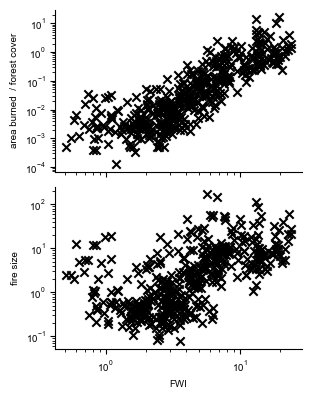

In [13]:
NUM_REGIONS = len(df_italy_matrix.columns)

YEARS = df_fwi.index
YEARS = YEARS[YEARS > 2002]
print(YEARS)

slopes = []
regions = df_italy_matrix.columns

regions = [('Italy', 'k'), ('Greece', None), ('Spain', None), ('Portugal', None)]

regions = [(c,  'k') for c in df_effis_area.columns[:-3]]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(PAGE_WIDTH/2, 4), sharex=True)

style_plot(ax1)
style_plot(ax2)

# save figure
fig.tight_layout()

for region, color in regions:
    ax1.scatter(df_fwi_eu[region].values, df_effis_area[region] / df_units_eu['FORESTCOVER'][region], color=color, label=region, marker='x')
    ax2.scatter(df_fwi_eu[region].values, df_effis_area[region] / df_effis_number[region], color=color, label=region, marker='x')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('FWI')
ax1.set_ylabel('area burned  / forest cover')
ax2.set_ylabel('fire size')

fig.tight_layout()
savefig(fig, 'fwi_fire_correlation')

# FWI Linear Model

In [14]:
def print_metrics(errors, print_control=False):
    if print_control:
        for m, M in [('average:', np.average), ('std', np.std), ('rmse', lambda x : np.sqrt(np.mean(x**2)))]:
            print(f'{m} (CONTROL)' , (M(errors[CONTROL].dropna(axis=1).loc[YEARS_TRAIN].values),
            M(errors[CONTROL].dropna(axis=1).loc[YEARS_TEST].values),
            M(errors[CONTROL].dropna(axis=1).loc[YEARS_VAL].values)))
    
    for m, M in [('average:', np.average), ('std', np.std), ('rmse', lambda x : np.sqrt(np.mean(x**2)))]:
        print(f'{m} (TREATED)' , (M(errors[TREATED].dropna(axis=1).loc[YEARS_TRAIN].values),
        M(errors[TREATED].dropna(axis=1).loc[YEARS_TEST].values),
        M(errors[TREATED].dropna(axis=1).loc[YEARS_VAL].values)))
        
def aggr_errors(errors, regions, metric):
    return (metric(errors[regions].dropna(axis=1).loc[YEARS_TRAIN].values),
            metric(errors[regions].dropna(axis=1).loc[YEARS_TEST].values),
            metric(errors[regions].dropna(axis=1).loc[YEARS_VAL].values))

In [15]:
def linear_model(df_ab, df_features, years_train, log=False, df_flammable_surface=None, joint=False, huber=False, positive=False, fit_intercept=True):
    df_pred = df_ab.copy()

    if joint:
        X_train = []
        Y_train = []
        for region in df_ab.columns:
            X = pd.DataFrame([df[region] for df in df_features]).T
            Y = df_ab[region]
            if df_flammable_surface is not None:
                Y /= df_flammable_surface[region]
            if log:
                Y = np.log(Y)

            X_train.append(X.loc[years_train].values)
            Y_train.append(Y.loc[years_train].values)
        if huber:
            model = HuberRegressor(fit_intercept=fit_intercept).fit(np.concatenate(X_train), np.concatenate(Y_train))
        else:
            model = LinearRegression(fit_intercept=fit_intercept, positive=positive).fit(np.concatenate(X_train), np.concatenate(Y_train))
            


    for region in df_ab.columns:
        X = pd.DataFrame([df[region] for df in df_features]).T

        if not joint:
            Y = df_ab[region]
            if df_flammable_surface is not None:
                Y /= df_flammable_surface[region]
            if log:
                Y = np.log(Y)
            if huber:
                model = HuberRegressor(fit_intercept=fit_intercept).fit(X.loc[years_train].values, Y.loc[years_train].values)
            else:
                model = LinearRegression(fit_intercept=fit_intercept, positive=positive).fit(X.loc[YEARS_TRAIN].values, Y.loc[YEARS_TRAIN].values)
                # print(model, model.coef_ , model.intercept_, region)
            
        y_pred = model.predict(X.values) 

        if log:
            y_pred = np.exp(y_pred)
        if df_flammable_surface is not None:
            y_pred *= df_flammable_surface[region]

        df_pred[region] = y_pred
    return df_pred

linear_model(df_italy_matrix, [df_fwi], years_train=YEARS_TRAIN, log=False, df_flammable_surface=None, joint=True, huber=True)

,Abruzzo,Basilicata,Calabria,Campania,Emilia-Romagna,Friuli-Venezia Giulia,Lazio,Liguria,Lombardia,Marche,Molise,Piemonte,Puglia,Sardegna,Sicilia,Toscana,Umbria,Veneto
Year,,,,,,,,,,,,,,,,,,
2003,2988.957891,3074.088196,2903.827586,4265.912464,4265.912464,5287.476123,4776.694293,3499.739720,1882.263928,2988.957891,2393.045757,860.700269,3755.130635,5883.388257,3499.739720,6053.648867,4776.694293,5202.345818
2004,3414.609415,3159.218501,3584.870025,3840.260940,1456.612403,-160.863389,4265.912464,2648.436672,-1182.427048,2988.957891,3074.088196,-927.036133,2648.436672,4436.173074,3925.391245,4180.782159,3755.130635,-245.993694
2005,1116.091184,2393.045757,2988.957891,1967.394233,860.700269,179.657830,2478.176062,1626.873013,349.918440,690.439659,1286.351794,9.397220,3499.739720,4776.694293,4265.912464,2222.785147,1797.133623,2393.045757
2006,1882.263928,2222.785147,3074.088196,1712.003318,860.700269,1201.221489,2307.915452,690.439659,-756.775523,1541.742708,1541.742708,-501.384609,2052.524537,5202.345818,4010.521550,3159.218501,2563.306367,-331.123999
2007,5032.085208,5968.518562,6053.648867,5627.997342,3329.479111,775.569964,4691.563989,2648.436672,2137.654842,4180.782159,5968.518562,945.830574,4691.563989,4606.433684,5713.127647,3925.391245,3925.391245,945.830574
2008,3670.000330,4606.433684,4776.694293,4436.173074,1712.003318,-586.514914,4180.782159,775.569964,-160.863389,4095.651854,4095.651854,264.788135,4691.563989,3755.130635,5117.215513,4010.521550,4265.912464,520.179050
2009,1712.003318,2988.957891,3670.000330,3244.348806,2137.654842,945.830574,2903.827586,1626.873013,-160.863389,1541.742708,1967.394233,-331.123999,2988.957891,4691.563989,4095.651854,4265.912464,2733.566976,1712.003318
2010,1371.482098,2307.915452,2563.306367,1882.263928,179.657830,9.397220,2478.176062,-331.123999,-1182.427048,690.439659,1967.394233,-1693.208877,3159.218501,2988.957891,3840.260940,1797.133623,1541.742708,-841.905828
2011,3584.870025,4010.521550,5457.736733,4180.782159,1967.394233,860.700269,3584.870025,2733.566976,775.569964,3840.260940,3584.870025,860.700269,3670.000330,4180.782159,5117.215513,3925.391245,3244.348806,1882.263928


# 3) Synthetic Control

In [16]:
def synthetic_control(X0, Y0, Phi0=None, joint_linear=True, verbose=False, convex_eq=True, constraint=1):
    """ 
        Computes synthetic control weights.
        
        Data control units pre-intervention:
        X0.shape = (num_features, num_control_units)
        
        Data treated units pre-intervention:
        Y0.shape = (num_features, num_treated_units)
        
        Computes argmin_w \|X0 w - Y0 \|_2    s.t.    w=probability vector
    """
   
    t, d = X0.shape
    _, n = Y0.shape
    w = cp.Variable((d, n))
    
    if Phi0 is None:
        cost = cp.sum_squares(X0 @ w - Y0)
    elif joint_linear:
        beta = cp.Variable(Phi0.shape[-1])
        cost = X0 @ w - Y0
        for i in range(Phi0.shape[2]):
            cost += Phi0[:,:,i] * beta[i]
        cost = cp.sum_squares(cost)
    else:
        beta = cp.Variable(Phi0.shape[-2:])
        cost = 0
        for j in range(Phi0.shape[1]):
            tmp_cost = X0 @ w[:, j] - Y0[:,j]
            
            for i in range(Phi0.shape[2]):
                tmp_cost += Phi0[:,j,i] * beta[j, i]
            cost += cp.sum_squares(tmp_cost)

    if convex_eq:
        prob = cp.Problem(cp.Minimize(cost), [cp.sum(w, axis=0) == constraint *  np.ones(n), w >= 0])
    else:
        prob = cp.Problem(cp.Minimize(cost), [cp.sum(w, axis=0) <= constraint * np.ones(n), w >= 0])
    prob.solve(verbose=verbose, max_iter=100000)
    
    # Print result.
    if verbose:
        print("\nThe optimal value is", prob.value)
        print("The optimal x is")
        print(w.value)
#         print("The norm of the residual is ", cp.norm((X0 @ w - Y0)/norm, p=2).value)
    if Phi0 is None:
        return w.value, None
    else:
        return w.value, beta.value

In [17]:
def apply_synthetic_control_loo(data, cols_control, cols_treated, t0, add_control_data=None, convex_eq=True, add_features=None, constraint=1):
    results  = []
    
    for col in cols_control:
        _cols_control = [c for c in cols_control if c != col]
        results.append(apply_synthetic_control(data, _cols_control, cols_treated, t0, add_control_data=add_control_data, convex_eq=convex_eq, add_features=add_features, constraint=constraint))
    return results

def apply_synthetic_control(data, cols_control, cols_treated, t0, add_control_data=None, verbose=False, add_features=None, joint_linear=True, return_weights=False, convex_eq=True, constraint=1):
    X0 = []
    Y0 = []
    Phi0 = [] if add_features is not None else None
    Phi = [] if add_features is not None else None

    for region in cols_control:
        features = []
        for df, weight in data:
            df_pre_intervention = df[df.index < t0] * weight
            features += df_pre_intervention[region].tolist()
        
        X0.append(features)
        
    for region in cols_treated:
        features = []
        for df, weight in data:
            df_pre_intervention = df[df.index < t0] * weight
            features += df_pre_intervention[region].tolist()
        
        Y0.append(features)
        if add_features is not None:
            Phi.append(add_features[region])
            
    X0 = np.array(X0).T
    Y0 = np.array(Y0).T


    if add_features is not None:
        Phi = np.array(Phi).swapaxes(0,1)
        Phi0 = Phi[:Y0.shape[0],:,:]
    
    if add_control_data is not None:
        df_add, weight_add = add_control_data
        X_add = df_add[cols_control].values * weight_add
        Y_add = df_add[cols_treated].values * weight_add
        X0 = np.vstack([X0, X_add])
        Y0 = np.vstack([Y0, Y_add])
    
    W, Beta = synthetic_control(X0, Y0, Phi0=Phi0, verbose=verbose, joint_linear=joint_linear, convex_eq=convex_eq, constraint=constraint)
    
    results = {}
    if Beta is not None:
        if joint_linear:
            for unit, w, phi in zip(cols_treated, W.T, Phi.swapaxes(0, 1)):        
                x1 = df[cols_control].values
                y1 = x1 @ w + phi@Beta
                results[unit] = y1
        else:
            for unit, w, phi, beta in zip(cols_treated, W.T, Phi.swapaxes(0, 1), Beta):        
                x1 = df[cols_control].values
                y1 = x1 @ w + phi@beta
                results[unit] = y1
            
    else:
        for unit, w in zip(cols_treated, W.T):        
            x1 = df[cols_control].values
            y1 = x1 @ w
            results[unit] = y1
        
    if return_weights:
        return pd.DataFrame(data=results,index=df.index.values.copy()), W, Beta
    return pd.DataFrame(data=results,index=df.index.values.copy())

In [18]:
def print_weights(results, threshold = 0.01):
    for unit in results['units_treated']:
        w = results[unit]['weights']
        mask = tuple([w >= threshold])
        print(f'{unit}: ' +', '.join([f"({r}, {wi:.2f})" for (r, wi) in zip(results['units_control'], w) if wi >= threshold]))

In [19]:
def grouped_bar_plot(data, periods, ax, colors={}, x=None):
    
    n_methods = len(data)
    if x is None:
        x = np.arange(len(periods))  # the label locations
    width = 1/(n_methods + 1)  # the width of the bars
    multiplier = 0

    for method, results in data.items():
        offset = width * multiplier - width * n_methods / 2 + width/2
        rects = ax.bar(x + offset, results, width, label=method, color=colors.get(method, None))
#         ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    # ax.set_ylabel('RMSE')

    ax.set_xticks(x)
    ax.set_xticklabels(periods,)


In [20]:
data_effis_sc = {
    'area burned (ha)' : (df_effis_area, df_effis_area , 1),
    'average fire size (ha)' : (df_effis_area / df_effis_number, df_effis_area / df_effis_number, 1),
    'FWI' : (df_fwi_eu, df_fwi_eu, 0),
}


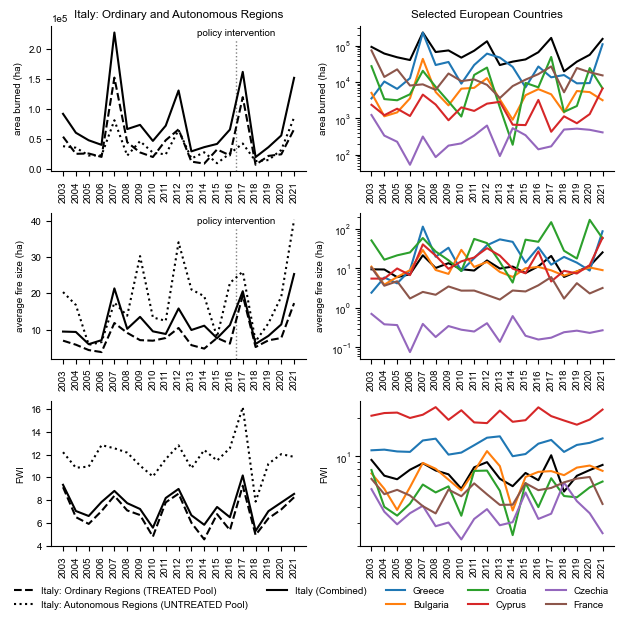

In [21]:
fig, axes = plt.subplots(len(data_effis_sc), 2, figsize=(PAGE_WIDTH, 6))

for (ax, ax2), (key, (data, data_normalized, add_policy_change)) in zip(axes, data_effis_sc.items()):


    ax.plot(YEARS, data['Italy TREATED'].values, label='Italy: Ordinary Regions (TREATED Pool)', color='k', linestyle='--')
    ax.plot(YEARS, data['Italy CONTROL'].values, label='Italy: Autonomous Regions (UNTREATED Pool)', color='k', linestyle=':')

    ax2.plot(YEARS, data_normalized['Italy'].values, label='Italy (Combined)', color='k')
    # add an invisible line to move labels to the right
    ax.plot(YEARS, data['Italy'].values, label='Italy (Combined)', color='k')
    # invisible line to shift labels 
    # ax.plot(YEARS, data_normalized['Italy TREATED'].values, label='   ', color='white', linestyle='--', alpha=0, linewidth=1)
    ax.plot(YEARS, data_normalized['Italy TREATED'].values, label='  ', color='white', linestyle='--', alpha=0, linewidth=1)

    ax2.plot(YEARS, data_normalized['Greece'].values, label='Greece') 
    ax2.plot(YEARS, data_normalized['Bulgaria'].values, label='Bulgaria')
    ax2.plot(YEARS, data_normalized['Croatia'].values, label='Croatia')
    ax2.plot(YEARS, data_normalized['Cyprus'].values, label='Cyprus')
    ax2.plot(YEARS, data_normalized['Czechia'].values, label='Czechia')
    # ax2.plot(YEARS, data_normalized['Slovakia'].values, label='Slovakia')
    # ax2.plot(YEARS, data_normalized['Spain'].values, label='Spain')
    ax2.plot(YEARS, data_normalized['France'].values, label='France')
    ax2.set_yscale('log')
    # ax2.plot(YEARS, data_normalized['Portugal'].values, label='Portugal')
    ax.set_ylabel(key)
    ax.set_xticks(YEARS)
    # rotate ticks
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')

    ax2.set_ylabel(key)
    ax2.set_xticks(YEARS)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, ha='center')
    # ax.legend()
    style_plot(ax, add_policy_change=add_policy_change)
    style_plot(ax2)

axes[0,0].set_title('Italy: Ordinary and Autonomous Regions')
axes[0,1].set_title('Selected European Countries')

axes[0,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# axes[0,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))


# Collect unique legend handles and labels
handles, labels = [], []
for ax in axes.flatten():
    for h, l in zip(*ax.get_legend_handles_labels()):
        
        if l not in labels:  # Avoid duplicates
            labels.append(l)
            handles.append(h)


# Create a single legend below all subplots
fig.legend(handles, labels, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.05), frameon=False)

# Adjust layout
# fig.tight_layout(rect=[0, 0.1, 1, 1])  # Leave space at bottom for legend

fig.tight_layout()
# fig.savefig(f'../plots/{timestamp}/{name}.png', dpi=300)
savefig(fig, 'fire_activity_italy')

In [22]:
COLS = ['Italy', 
        'Portugal', 
        'Spain', 
        'France', 
        'Greece', 
        'Austria', 
        'Bulgaria',
       'Croatia', 
       'Cyprus', 
       'Czechia', 
    #    'Estonia', 
    #    'Finland', 
       'Germany',
       'Hungary', 
    #    'Latvia', 
    #    'Lithuania', 
    #    'Norway', 
       'Poland', 
       'Romania',
       'Slovakia', 
       'Slovenia', 
    #    'Sweden', 
       'Switzerland', 
       'Türkiye',
       'Italy TREATED', 
       'Italy CONTROL']

df_mean_activity = df_effis_area[COLS].loc[YEARS_TRAIN].mean(axis=0)
df_mean_fire_size = (df_effis_area[COLS] / df_effis_number[COLS]).loc[YEARS_TRAIN].mean(axis=0)

data_effis_sc = {
    'area burned (ha)' : (df_effis_area[COLS] / df_units_eu['FORESTCOVER'][COLS], df_units_eu['FORESTCOVER'][COLS]),
    'average fire size (ha)' : (df_effis_area[COLS] / df_effis_number[COLS], 1),
}

Italy: Ordinary Regions (TREATED Pool) area burned (ha) without FWI
Absolute weights: Bulgaria: 0.50, Croatia: 0.33, Greece: 0.16, Portugal: 0.00
Relative weights Greece: 0.31, Croatia: 0.29, Bulgaria: 0.18, Portugal: 0.04
Italy: Ordinary Regions (TREATED Pool) area burned (ha) with FWI
Absolute weights Bulgaria: 0.84, Greece: 0.10, Croatia: 0.05, Portugal: 0.00
Relative weights Bulgaria: 0.30, Greece: 0.20, Croatia: 0.04, Portugal: 0.04
Italy: Ordinary Regions (TREATED Pool) average fire size (ha) without FWI
Absolute weights: Slovakia: 0.23, Türkiye: 0.20, Czechia: 0.20, France: 0.17
Relative weights Cyprus: 0.31, Türkiye: 0.11, Croatia: 0.09, Bulgaria: 0.08
Italy: Ordinary Regions (TREATED Pool) average fire size (ha) with FWI
Absolute weights Czechia: 0.56, Türkiye: 0.15, Cyprus: 0.13, France: 0.09
Relative weights Cyprus: 0.31, Bulgaria: 0.10, Türkiye: 0.08, France: 0.04
Italy: Autonomous Regions (UNTREATED Pool) area burned (ha) without FWI
Absolute weights: Greece: 0.63, Croatia

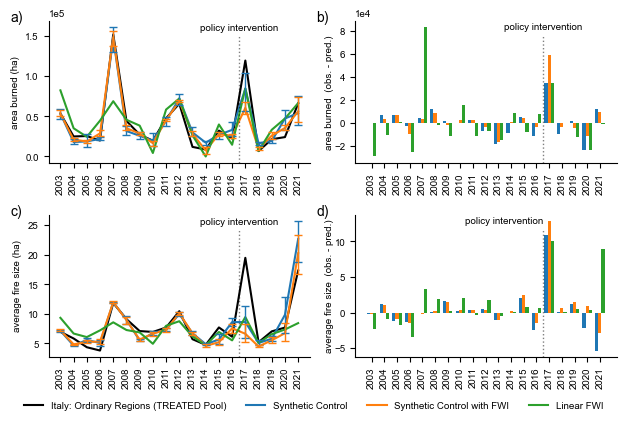

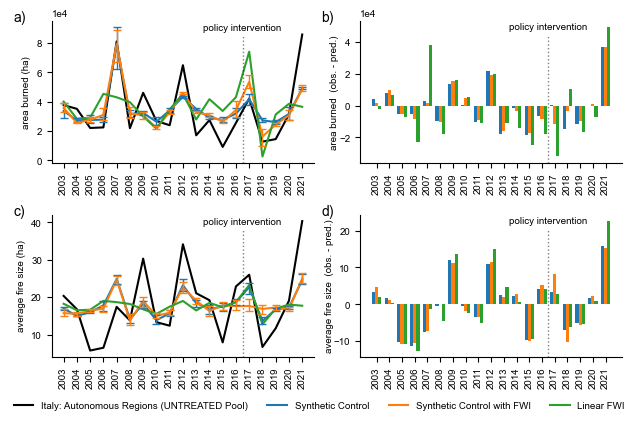

In [23]:
weights = {}
table = {}

SPLITS = [YEARS_TRAIN, YEARS_TEST, [2017], YEARS_VAL[1:], YEARS_VAL]
SPLIT_YEARS = [[y] for y in YEARS]
CONFIGS = [
    {
        'file' : 'synthetic_control_ordinary',
        'target' : 'Italy TREATED',
        'title' : 'Italy: Ordinary Regions (TREATED Pool)',
        'loo' : True,
        'fwi' : True,
        'linear' : True
    },

    {
        'file' : 'synthetic_control_autonomous',
        'target' : 'Italy CONTROL',
        'title' : 'Italy: Autonomous Regions (UNTREATED Pool)',
        'loo' : True,
        'fwi' : True,
        'linear' : True
    },
]

RMSE = []

for config in CONFIGS:


    TARGET = config['target']
    fig, _axes = plt.subplots(2, len(data_effis_sc), figsize=(PAGE_WIDTH, 4))
    axes, axes2 = _axes.T

    for ax, ax2, (key, (data, df_norm)) in zip(axes, axes2, data_effis_sc.items()):
        mean_data = data.loc[YEARS_TRAIN].mean(axis=0)

        bar_plot_data ={}
        # PLAIN SYNTHETIC CONTROL  
        controls= [c for c in data.columns if c not in ['Italy', 'Italy TREATED', 'Italy CONTROL']]
        # OBSERVED VALUES
        df_obs = data
        if 'log' in key:
            df_obs = np.exp(df_obs)

        ax.plot(YEARS, (df_obs * df_norm)[TARGET].values, color=f'k', linestyle='-', label=config['title'])
        add_features = dict()
        add_features[TARGET] = np.ones((1, len(YEARS)))
        # if not (config['loo'] and config['fwi']):
        df_sc, W, Beta = apply_synthetic_control(
                data=[(data, 1.),] ,
                cols_control=controls, 
                cols_treated=[TARGET],
                t0=YEARS_TEST[0],
                add_control_data=None,
                return_weights=True,
                convex_eq=False,
                add_features=add_features
        )

        print(config['title'], key, 'without FWI')
        print("Absolute weights:", ", ".join([f"{c}: {w.item():.2f}" for c, w in [*sorted(zip(controls, W), key=lambda x:-x[1])][:4]]))
        Z = W.flatten() * mean_data[controls].values / mean_data[TARGET]
        print("Relative weights", ", ".join([f"{z}: {w.item():.2f}" for z, w in [*sorted(zip(controls, Z), key=lambda x:-x[1])][:4]]))
        


        if 'log' in key:
            df_sc = np.exp(df_sc)

        ax.plot(YEARS, (df_sc * df_norm)[TARGET].values, linestyle='-', label='Synthetic Control', color='C0')
        bar_plot_data['Synthetic Control'] = (data * df_norm - df_sc * df_norm)[TARGET] 

        # compute rmse over each split
        RMSE.append(((TARGET, key,'Synthetic Control'), get_rmse(df_sc * df_norm, data * df_norm, TARGET, SPLITS)))
    

        # SYNTHETIC CONTROL WITH FWI FEATURES
        if config['fwi']:
            add_data = pd.DataFrame({
                'FWI' : df_fwi_eu[TARGET] if not 'log' in key else np.log(df_fwi_eu[TARGET]), 
                #  'FWI_LOG' : np.log(df_fwi_eu[TARGET])
                })
            add_data['C'] = 1
            add_features = dict()
            add_features[TARGET] = add_data.loc[YEARS].values

            df_sc, W, Beta = apply_synthetic_control(
                    data=[(data, 1.),] ,
                    cols_control=controls, 
                    cols_treated=[TARGET],
                    t0=YEARS_TEST[0],
                    add_control_data=None,
                    return_weights=True,
                    convex_eq=False,
                    add_features=add_features,
            )

            print(config['title'], key, 'with FWI')
            Z = W.flatten() * mean_data[controls].values / mean_data[TARGET]
            print("Absolute weights", ", ".join([f"{c}: {w.item():.2f}" for c, w in [*sorted(zip(controls, W), key=lambda x:-x[1])][:4]]))
            print("Relative weights", ", ".join([f"{z}: {w.item():.2f}" for z, w in [*sorted(zip(controls, Z), key=lambda x:-x[1])][:4]]))
            if 'log' in key:
                df_sc = np.exp(df_sc)

            ax.plot(YEARS, (df_sc * df_norm)[TARGET].values, linestyle='-', label='Synthetic Control with FWI', color='C1')
            bar_plot_data['Synthetic Control + FWI'] = (data * df_norm - df_sc * df_norm)[TARGET] 
            
            RMSE.append(((TARGET, key,'Synthetic Control + FWI'), get_rmse(df_sc * df_norm, data * df_norm, TARGET, SPLITS)))


        # add linear model
        if config['linear']:
            df_linear_pred = linear_model(data[[TARGET]], [df_fwi_eu[[TARGET]]], log=False, years_train=YEARS_TRAIN, joint=False, huber=False)
            ax.plot(YEARS, (df_linear_pred * df_norm)[TARGET].values, linestyle='-', label='Linear FWI', color='C2')
            bar_plot_data['Linear FWI'] = (data * df_norm - df_linear_pred * df_norm)[TARGET] 

            RMSE.append(((TARGET, key,'Linear FWI'), get_rmse(df_linear_pred * df_norm, data * df_norm, TARGET, SPLITS)))

        if config['loo']:
            # LEAVE-ONE-OUT SYNTHETIC CONTROL
            add_features = dict()
            add_features[TARGET] = np.ones((1, len(YEARS)))
            res_loo = apply_synthetic_control_loo(
                    data=[(data, 1.),] ,
                    cols_control=controls, 
                    cols_treated=[TARGET],
                    t0=YEARS_TEST[0],
                    convex_eq=False,
                    add_features=add_features
            )

            res_loo = np.array([(r * df_norm)[TARGET] for r in res_loo])

            # Compute mean and standard deviation across LOO estimates
            mean_loo = np.mean(res_loo, axis=0)
            std_loo = np.std(res_loo, axis=0, ddof=1)  # Unbiased estimator

            # Compute 95% confidence bands using normality assumption
            z_value = 1.96  # For 95% confidence interval
            ci_upper = mean_loo + z_value * std_loo
            ci_lower = mean_loo - z_value * std_loo

            # ax.fill_between(YEARS, ci_lower, ci_upper, color='C0', alpha=0.4, linewidth=0) 
            ax.errorbar(YEARS, mean_loo, yerr=z_value * std_loo, color='C0', capsize=3, linestyle='', linewidth=1)
            # for _d in res_loo:
            #     ax.plot(YEARS, _d, linestyle='-', color='C0' if not config['fwi'] else 'C0', linewidth=0.5)


            # LEAVE-ONE-OUT SYNTHETIC CONTROL with FWI
            if config['fwi']:
                add_data = pd.DataFrame({
                                'FWI' : df_fwi_eu[TARGET] if not 'log' in key else np.log(df_fwi_eu[TARGET]), 
                #  'FWI_LOG' : np.log(df_fwi_eu[TARGET])
                })
                add_data['C'] = 1
                add_features = dict()
                add_features[TARGET] = add_data.loc[YEARS].values
                res_loo = apply_synthetic_control_loo(
                        data=[(data, 1.),] ,
                        cols_control=controls, 
                        cols_treated=[TARGET],
                        t0=YEARS_TEST[0],
                        convex_eq=False,
                        add_features=add_features
                )


                res_loo = np.array([(r * df_norm)[TARGET] for r in res_loo])
                # Compute mean and standard deviation for FWI case
                mean_loo_fwi = np.mean(res_loo, axis=0)
                std_loo_fwi = np.std(res_loo, axis=0, ddof=1)

                # Compute confidence bands
                ci_upper_fwi = mean_loo_fwi + z_value * std_loo_fwi
                ci_lower_fwi = mean_loo_fwi - z_value * std_loo_fwi

                # Plot mean and confidence bands
                # ax.plot(YEARS, mean_loo_fwi, linestyle='-', color='C1', linewidth=1.5, label='LOO Mean (FWI)')
                # ax.fill_between(YEARS, ci_lower_fwi, ci_upper_fwi, color='C1', alpha=0.4, linewidth=0)
                ax.errorbar(YEARS, mean_loo_fwi, yerr=z_value * std_loo_fwi, color='C1', capsize=3, linestyle='', linewidth=1)



        # ax.set_title(key)# + ' ' + title[TARGET])
        ax.set_xticks(YEARS)
        ax.set_ylabel(key)
        # rotate ticks
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
        style_plot(ax, add_policy_change=True)



        # weights[key] = [(c, w.item()) for c, w in zip(controls, W)]

        # grouped_bar_plot(bar_plot_data, ['2003-2011', '2012-2016', '2017', '2018-2021'], ax2)
        grouped_bar_plot(bar_plot_data, [str(y) for y in YEARS], ax2, x=YEARS)
        ax2.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')

        # ax2.set_title(key)
        ax2.set_ylabel(key[:-4] + ' (obs. - pred.)', labelpad=0)

        # if config['file'] == 'synthetic_control_ordinary':
        #     axes2[1].set_ylim(0,14)
        style_plot(ax2, add_policy_change=True, ha='right' if config['file'] == 'synthetic_control_ordinary' and key == 'average fire size (ha)' else 'center')
    

    # axes[0,0].set_title('Italy')
    # axes[0,1].set_title('European Countries')
    axes[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    axes2[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))


    # Collect unique legend handles and labels
    handles, labels = [], []
    for ax in axes.flatten():
        for h, l in zip(*ax.get_legend_handles_labels()):
            if l not in labels:  # Avoid duplicates
                labels.append(l)
                handles.append(h)

    # Create a single legend below all subplots
    fig.legend(handles, labels, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.05), frameon=False)


    # add labels a), b), c), d) to the subplots
    for i, ax in enumerate(_axes.flatten()):
        ax.text(-0.1, 1.07, chr(97 +i) + ')', transform=ax.transAxes, fontsize=10,
                verticalalignment='top', horizontalalignment='right')



    fig.subplots_adjust()
    fig.tight_layout()

    
    savefig(fig, config['file'])

# save rmse values to csv
rmse_data = []
for (data, rmse) in RMSE:
    rmse_data.append([f'{data[0]} {data[1]} {data[2]}', *[f"{r:.1f}" for r in rmse]])

df_rmse = pd.DataFrame(rmse_data, columns=['Model', '2003-2014', '2015-2016', '2017', '2018-2021', '2017-2018'])
# df_rmse.to_csv('synthetic_control_rmse.csv', index=False, header=True)


In [24]:
data_effis_sc = {
    'normalized area burned' : (df_effis_area / df_units_eu['FORESTCOVER'], df_units_eu['FORESTCOVER']),
    'average fire size' : (df_effis_area / df_effis_number, 1),
}

15
control ['Puglia', 'Lombardia', 'Marche', 'Molise', 'Piemonte', 'Toscana', 'Umbria', 'Veneto', 'Portugal', 'Spain', 'France', 'Greece', 'Austria', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Estonia', 'Finland', 'Germany', 'Hungary', 'Latvia', 'Lithuania', 'Norway', 'Poland', 'Romania', 'Slovakia', 'Slovenia', 'Sweden', 'Switzerland', 'Türkiye']
treated ['Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia-Romagna', 'Lazio', 'Liguria']
control ['Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia-Romagna', 'Lazio', 'Liguria', 'Portugal', 'Spain', 'France', 'Greece', 'Austria', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Estonia', 'Finland', 'Germany', 'Hungary', 'Latvia', 'Lithuania', 'Norway', 'Poland', 'Romania', 'Slovakia', 'Slovenia', 'Sweden', 'Switzerland', 'Türkiye']
treated ['Lombardia', 'Marche', 'Molise', 'Piemonte', 'Puglia', 'Toscana', 'Umbria', 'Veneto']


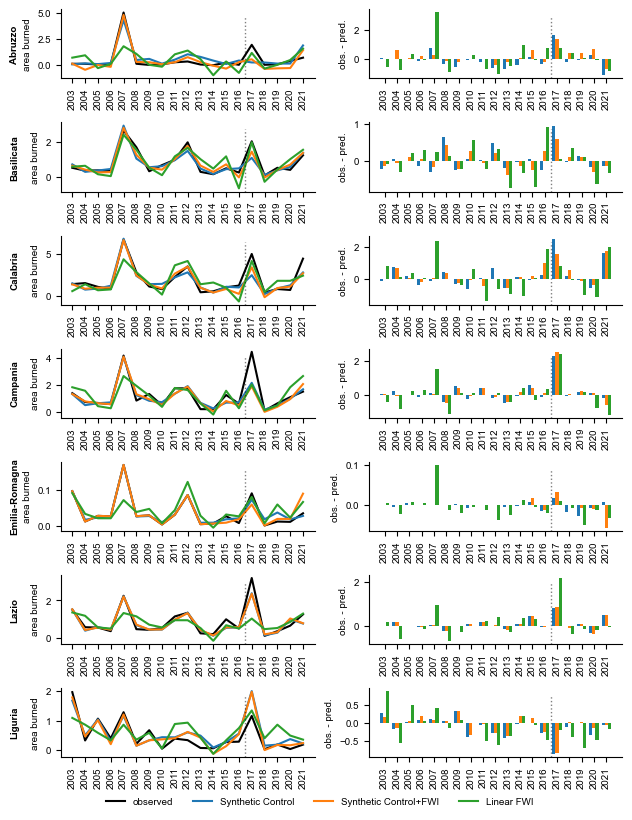

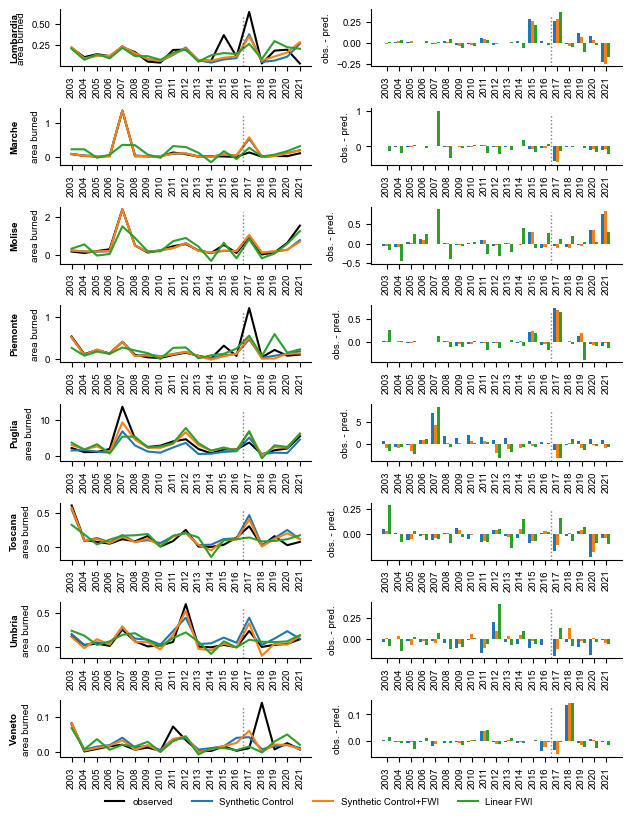

In [25]:
df_italy = df_italy_matrix / df_units['FORESTCOVER']
df_europe = df_effis_area / df_units_eu['FORESTCOVER']
metric = 'area burned'


df_italy_treated = df_italy[TREATED].copy()
# add suffix to treated regions

df_combined = pd.concat([df_italy_treated, df_europe.drop(columns=['Italy', 'Italy TREATED', 'Italy CONTROL'])], axis=1)


print(len(TREATED))

treated_sorted = sorted(df_italy_treated.columns.values)

for part, treated in enumerate([treated_sorted[:7], treated_sorted[7:]]):

    fig, axes = plt.subplots(len(treated), 2, figsize=(1.*PAGE_WIDTH, 8), sharex=False)
    control = [c for c in df_combined.columns if c not in treated and not 'Italy' in c]
    print('control', control)
    print('treated', treated)




    for i, (region, (ax, ax2)) in enumerate(zip(treated, axes)):

        bar_plot_data ={}
        ax.plot(YEARS, df_italy_treated[region].values, color=f'k', linestyle='-', label='observed')
        df_sc = apply_synthetic_control(
            data=[(df_combined, 1.),] ,
            cols_control=control, 
            cols_treated=[region],
            t0=YEARS_TEST[0],
            add_control_data=None,
        )

        ax.plot(YEARS, df_sc[region].values, linestyle='-', label='Synthetic Control')
        bar_plot_data['Synthetic Control'] = (df_italy_treated[region] - df_sc[region]) #get_rmse(df_sc * df_norm, data * df_norm, TARGET, SPLITS)

        add_data = pd.DataFrame({
                'FWI' : df_fwi[region], 
                #  'FWI_LOG' : np.log(df_fwi_eu[TARGET])
                })
        add_data['C'] = 1
        add_features = dict()
        add_features[region] = add_data.loc[YEARS].values

        df_sc = apply_synthetic_control(
            data=[(df_combined, 1.),] ,
            cols_control=control, 
            cols_treated=[region],
            t0=YEARS_TEST[0],
            add_control_data=None,
            add_features=add_features
        )

        ax.plot(YEARS, df_sc[region].values, linestyle='-', label='Synthetic Control+FWI')

        bar_plot_data['Synthetic Control+FWI'] = (df_italy_treated[region] - df_sc[region]) #get_rmse(df_sc * df_norm, data * df_norm, TARGET, SPLITS)


        df_linear_pred = linear_model(df_combined[[region]], [df_fwi[[region]]], years_train=YEARS_TRAIN, joint=False, huber=False)
        ax.plot(YEARS, df_linear_pred[region].values, linestyle='-', label='Linear FWI', color='C2')
        bar_plot_data['Linear FWI'] = (df_italy_treated[region] - df_linear_pred[region])

        # ax.plot(YEARS, df_sc_results_log[region].values, linestyle='-', label='SC log')

        # ax.legend()
        # ax.set_title(region)
        # ax2.set_title(region)
        ax.set_xticks(YEARS)
        # rotate ticks
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', fontsize=7)
        # ax.set_ylabel(metric)
        ax.text(s=region, rotation='vertical', x=-0.2, y=0.5, va='center', transform = ax.transAxes, weight='bold')
        ax.set_ylabel(metric)
        ax2.set_ylabel('obs. - pred.')
        style_plot(ax, add_policy_change='line')
        grouped_bar_plot(bar_plot_data, [str(y) for y in YEARS], ax2, x=YEARS)
        ax2.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')

        style_plot(ax2, add_policy_change='line')

    # Collect unique legend handles and labels
    handles, labels = [], []
    for ax in axes.flatten():
        for h, l in zip(*ax.get_legend_handles_labels()):
            if l not in labels:  # Avoid duplicates
                labels.append(l)
                handles.append(h)

    # for row in axes:
    #     row[0].set_ylabel(ylabel)
        
    # fig.suptitle(metric, fontsize=8)
    # Create a single legend below all subplots
    fig.legend(handles, labels, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.02), frameon=False)

    # Adjust layout
    # fig.tight_layout(rect=[0, 0.1, 1, 1])  # Leave space at bottom for legend

    fig.subplots_adjust()
    fig.tight_layout()
    savefig(fig, f'synthetic_control_regions_{part}_{metric}')
